# Training Models

We will practice training machine learning models for both regression and for classification problems. 

# 1) Regression Models

We will start by fitting regression models. We will download the time series of the GPS station deployed on Montague Island.

<img src="AC29_map.png" alt="AC29 GPS stations on Montague Island" width="600"/>

In [1]:
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline

In [2]:
# Download data
sta="AC29"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
#             # errors
    se.append(float(crap[10])*1000)
    sn.append(float(crap[11])*1000)
    sv.append(float(crap[12])*1000)

  # make dataframe
crap={'station':sta,'date':date,'date_year':date_year,'east':ue,'north':un,'up':uv}
if len(df)==0:
    df = pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])
else:
    df=pd.concat([df,pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])])
df.head()


,station,date,date_year,east,north,up
0,AC29,14AUG18,2014.6283,0.000,0.000,0.000
1,AC29,14AUG19,2014.6311,-2.095,1.439,0.641
2,AC29,14AUG20,2014.6338,-1.860,2.458,2.975
3,AC29,14AUG21,2014.6366,-2.864,3.331,-1.342
4,AC29,14AUG22,2014.6393,-2.541,4.917,1.917


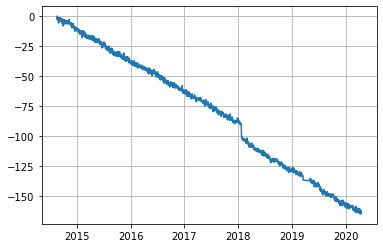

In [3]:
# select the first 2 years of data from the east component
y = ue[0:365*5]
plt.plot(df['date_year'],df['east']);plt.grid(True)

### 1.1 Linear regression

Let $y$ be the data, and $\hat{y}$ be the predicted value of the data. A general linear regression can be formulated as

$\hat{y} = w_0 + w_1 x_1 + ... + w_n x_n = h_w (\mathbf{x})$.

$\mathbf{\hat{y}} = \mathbf{G} \mathbf{w}$.

$y$ is a data vector of length $m$, $\mathbf{x}$ is a feature vector of length $n$. $\mathbf{w}$ is a vector of model parameter, $h_w$ is refered to as the *hypothesis function* or the *model* using the model parameter $w$. In the most simple case of a linear regression with time, the formulation becomes:

$\hat{y} = w_0 + w_1 t$,

where $x_1 = t$ the time feature.

To evaluate how well the model performs, we will compute a *loss score*, or a *residual*. It is the result of applying a *loss* or *cost* or *objective* function to the prediction and the data. The most basic *cost function* is the **Mean Square Error (MSE)**:

$MSE(\mathbf{x},h_w) = \frac{1}{m} \sum_{i=1}^{m} \left( h_w(\mathbf{x})_i - y_i  \right)^2  = \frac{1}{m} \sum_{i=1}^{m} \left( \hat{y}_i - y_i  \right)^2 $, in the case of a linear regression.

The *Normal Equation* is the solution to the linear regression that minimize the MSE.

$\mathbf{w} = \left( \mathbf{x}^T\mathbf{x} \right)^{-1} \mathbf{x}^T \mathbf{y}$

This compares with the classic inverse problem framed by $\mathbf{d} = \mathbf{G} \mathbf{m}$.

$\mathbf{m} = \left( \mathbf{G}^T\mathbf{G} \right)^{-1} \mathbf{G}^T \mathbf{d} $

It can be solved using Numpy linear algebra module. If $\left( \mathbf{x}^T\mathbf{x} \right) $ is singular and cannot be inverted, a lower rank matrix called the *pseudoinverse* can be calculated using singular value decomposition. We also used in a previous class that the Scikit-learn function for ``sklearn.linear_model.LinearRegression``, which is the implementation of the *pseudoinverse* We practice below how to use these standard inversions:

[[1.     0.    ]
 [1.     0.0028]
 [1.     0.0055]
 ...
 [1.     1.9905]
 [1.     1.9932]
 [1.     1.9959]]
LinearRegression()
modeled parameters. Normal equation
[ -1.46785681 -26.01925682]
modeled parameters. pseudoinverse
[ -1.46785681 -26.01925682]


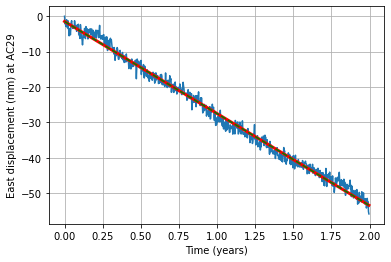

In [4]:
x = np.asarray(date_year[0:2*365]) 
x = x-np.min(x)
y = np.asarray(ue[0:2*365])
G = np.c_[np.ones((2*365,1)),x]
m = len(y)
print(G)

#normal equation
w1 = np.linalg.inv(G.T.dot(G)).dot(G.T).dot(y)

# Pseudoinverse
w2 = np.linalg.pinv(G).dot(y)

# scikitlearn LinearRegression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x.reshape(1,-1),y.reshape(1,-1))
print(lin_reg)
w3 = [lin_reg.intercept_, lin_reg.coef_]

y_predict1=G.dot(w1)
y_predict2=G.dot(w2)
y_predict3=lin_reg.predict(x.reshape(1,-1))

plt.plot(x,y);plt.grid(True)
plt.plot(x,y_predict1,'r',linewidth=3);
plt.plot(x,y_predict2,'g--');
plt.plot(x.reshape(1,-1),y_predict3,'k');
plt.xlabel("Time (years)")
plt.ylabel('East displacement (mm) at AC29')

print("modeled parameters. Normal equation")
print(w1)
print("modeled parameters. pseudoinverse")
print(w2)

## 1.2 Loss functions for regressions

Loss functions are used to measure the difference between the data and the predictions. Loss functions $\mathcal{L}(\mathbf{w}) $ are differentiable with respect to models.

In the previous example, we used the MSE as a loss function:

$ MSE(\mathbf{x},h_w) = \frac{1}{m} \sum_{i=1}^m \left( \hat{y}_i - y_i \right) ^2 $

The regression aims to find $h_w$ that minimizes the loss function $\mathcal{L}(\mathbf{w}) $. Other examples of loss functions are:

$MAE(\mathbf{x},h_w) = \frac{1}{m} \sum_{i=1}^m |\hat{y}_i - y_i|$


You can find interesting comparisons of Loss functions for regression problems here: https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0


# 2) Gradient Descent

Gradient Descent is used to *train* machine learning models.
Gradient Descent marches down the misfit function through the parameter space: it evaluates the loss function and attempting to find its global minimum. The model $\mathbf{w}$ is updated iteratively in the direction that reduces the loss/misfit:

$w_j^{(k + 1)} = w_j^{(k)} - \alpha \frac{\partial \mathcal{L}}{\partial w_j}$ for $j = 1 , \cdots , n ,$
 
where $\alpha$ is the **learning rate**.

<table><tr>
<td> <img src="GD_cartoon.jpeg" alt="Gradient Descent" style="width: 400px;"/>  </td>
<td> <img src="GD_non_global.png" alt="Gradient Descent non convex" style="width: 400px;"/> </td>
</tr>
<tr>
<td>Gradient descent for a convex, well behaved loss function. </td>
<td> Gradient descent in a poorly behaved loss function with local minima. <td>
</tr>
</table>

## 2.1 Batch Gradient Descent
Batch GD is performing the GD over the entire data and taking the steps to go down the gradient by finding the appropriate learning rate $\alpha$. 
<table><tr>
<td> <img src="GD_AlphaTooSmall.png" alt="Learning rate too small" style="width: 400px;"/> </td>
<td> <img src="GD_AlphaTooLarge.png" alt="Learning rate too large" style="width: 400px;"/> </td>
</tr>
<tr>
<td>Learning rate $\alpha$ is too small. It will take longer to converge. </td>
<td> Learning rate $\alpha$ is too large. Converge to global minimum.  <td>
</tr>
</table>
The iteration in GD can be stopped by imposing a convergence rate (tolerance) that is a thershold under which the error will not longer be calculated. Gradient Descent require re-scaling the data.

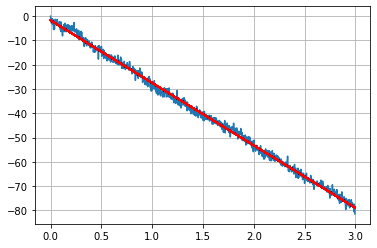

In [5]:
# normalize the data. Without normalization this will fail!
x = np.asarray(date_year[0:3*365]).reshape(-1,1)
y = np.asarray(ue[0:3*365]).reshape(-1,1)
x = x-np.min(x)
G = np.c_[np.ones((len(x),1)),x]
scale = (np.max(y)-np.min(y)) # minmax scaling
newy = y / scale
plt.plot(x,newy*scale);plt.grid(True)

alpha = 0.1
n_iterations =1000
for k in range(100): # perform 100 times the random initialization
    w = np.random.rand(2,1) # initialize the model parameters.
    for iteration in range(n_iterations):
        gradients = 2/m *G.T.dot(G.dot(w)-newy.reshape(-1,1))
        w = w - alpha * gradients  

    plt.plot(x,G.dot(w)*scale,'r')

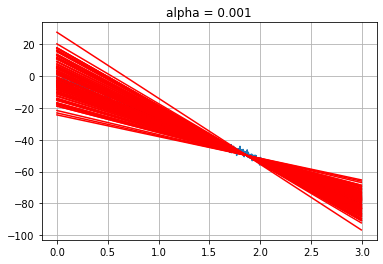

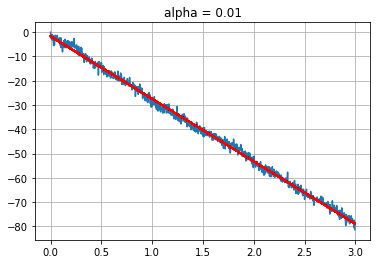

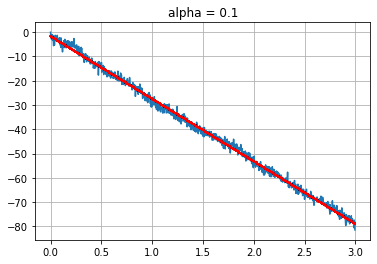

In [6]:
# Now let's vary the learning rate
n_iterations =1000
for alpha in [0.001,0.01,0.1]:
    fig,ax=plt.subplots(1,1)    
    ax.plot(x,newy*scale);ax.grid(True)
    for k in range(100): # perform 100 times the random initialization
        w = np.random.rand(2,1) # initialize the model parameters.
        for iteration in range(n_iterations):
            gradients = 2/m *G.T.dot(G.dot(w)-newy.reshape(-1,1))
            w = w - alpha * gradients  

        ax.plot(x,G.dot(w)*scale,'r')
        ax.set_title("alpha = "+str(alpha))

## 2.2 Stochastic Gradient Descent
SGD takes the gradient for each single instance. By default, SGD in Scikit-learn will minimize the MSE cost function. The advantages of GD are:
* Efficiency.
* Ease of implementation (lots of opportunities for code tuning).

The disadvantages of Stochastic Gradient Descent include:

* SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.

* SGD is sensitive to feature scaling.

[-1.829814099987479, -25.694140563129707]


/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


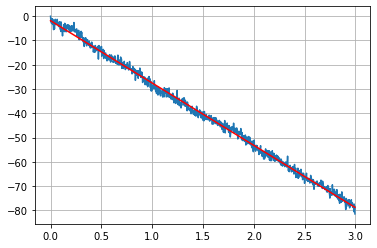

In [7]:
from sklearn.linear_model import SGDRegressor
alpha = 0.01 # learning rate
sgd_reg = SGDRegressor(max_iter=1000,tol=1e-2,penalty=None,eta0=alpha)
sgd_reg.fit(x,y)
w=[sgd_reg.intercept_[0],sgd_reg.coef_[0]]
print(w)

fig,ax=plt.subplots(1,1)    
ax.plot(x,y);ax.grid(True)
ax.plot(x,G.dot(w),'r')

## 2.3 Mini Batch Gradient Descent
It is a combination of Batch GD and SGD. Minibatch computes the gradient over a subset of instances (as against a single one in SGD or the full one in Batched GD). At each step, using one minibatch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss. 



# 2) Under-fitting and Overfitting


**Bias**
This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data. Biased is reduced by adjusting, optimizing the model to get the best performance possible on the training data.

**Variance**
This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data. Variance is reduced

**Irreducible error**
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).


**Underfitting**: the model is too simple, the bias is high but the model variance is low. This occurs in most cases at the beginning of training, where the model has not yet learned to fit the data. With iterative training, the algorithm starts by underfitting the data (high loss for both validation and training data) and progressively "learn" and improve the fit. It remains a problem with the loss in both training and validation have high values. 

The solution is to increase the complexity of the model, or to design better feature from the data (feature engineering), and to reduce the constrains on the model (such as the parameterization of model regularization). Underfitting is identified by having a high bias and low variance of the residuals. It is usually obvious and rarely a problem because the training and validation errors are high.


**Overfitting**: the model is too complex, the bias is low but the model variance is high. Data may contain noise that should not be fit by the algorithm. It happens when the model is too complex relative to the amount and the noisiness of the training data. Overfitting is a common problem in geoscience machine learning problems. Overfitting can be detected when the model performs perfectly on the training data, but poorly on the validation and test data. It can also be detected using **cross-validation metrics** and **learning curves**.

Some solutions are to reduce the model size, reduce the number of attributes in the training data, gather more training data, to reduce the noise in the training data (fix data errors and remove outliers). Another way to keep the model complexity but constrain its variance is called **regularization**.  


***You do not know if you overfit, until you do***. The model may not be complex enough until your reached overfitting. Once reached, back up a little bit to find the best tradeoff in optimization and generalization.


**Assessing Overfitting**

To evaluate the model's ability to generalize to other data sets, and have the appropriate level of variance, we plot **learning curves**. These plots the model performance on the training and validation set as a function of the training set size. 

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y,c1="b+",c2="b"):
    # Setting the random_state variable in the train_test_split is necessary to reproduce the results. 
    # When tuning parameters such as test_size, you need to set the random state otherwise too many parameters change.
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2,random_state=42)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), c1, linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors),c2, linewidth=3, label="val")
    plt.legend(['training','validation'])
    plt.grid(True)
    plt.title("Learning curve")
    plt.ylabel("RMSE")
    plt.xlabel('Training size')

/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Text(0, 0.5, 'East displacement (mm) at AC29')

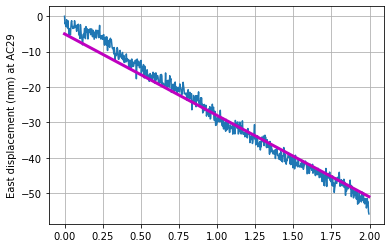

In [9]:
x = np.asarray(date_year[0:2*365]).reshape(-1,1)
y = np.asarray(ue[0:2*365]).reshape(-1,1)
x = x-np.min(x)
# G = np.c_[np.ones((len(x),1)),x]
scale = (np.max(y)-np.min(y)) # minmax scaling
newy = y / scale
alpha = 0.01 # learning rate
sgd_reg = SGDRegressor(max_iter=1000,tol=1e-2,penalty=None,eta0=alpha)
sgd_reg.fit(x,newy)
y_predict=sgd_reg.predict(x)

plt.plot(x,y);plt.grid(True)
plt.plot(x,y_predict*scale,"m",linewidth=3)
plt.ylabel('East displacement (mm) at AC29')

(1.0, 2.0)

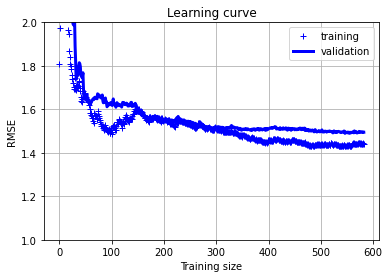

In [10]:
plot_learning_curves(sgd_reg, x.ravel(), y.ravel())
plt.ylim([1,2])

Let's read and interpret these curves.

You will notice that when you re-run the cell with ``plot_learning_curves`` that you will get different answers: this is because the initialization of the SGD will give different answers. This is a first reason why one should run these multiple times and then average over the curves.


* **The good signs**:

Loss curves plateau at low value for both training and validation. Training loss should be smaller, but not by much, than the validation loss. Low loss values are signs of good fit and good generalization.


* **The bad signs: underfitting**:

RMSE are high for both training and validation.

* **The bad signs: overfitting**:

RMSE is low for training but high for validation.

# 3) Regularization

Constraining a model of a given complexity to make it simpler is called **regularization**. 

## 3.1 Ridge Regression

To regularize the model, we can reduce model parameter variance by imposing that the norm of the model parameters is small. Assuming that the model parameters follow a normal (Gaussian) distribution, we want to minimize the L2 norm (equivalent to the mean square of the model parameters:

$\mathcal{L}(\mathbf{w})  = MSE(\mathbf{w})  + \lambda \frac{1}{2} || \mathbf{w} ||_2^2$, 

where $|| \mathbf{w} ||_2 = \sum_{i=1}^n w_i^2$ is the L2 norm of the model parameters, $\lambda$ is a hyperparameter to tune to balance the contribution of model norm as against the residual norms. L2 norm is sensitive to outliers in the distributions. 
Ridge Regression is sensitive to data scale, so do not forget to scale input data.


## 3.2 Lasso Regression
Lasso Regression is just like the Ridge Regression a way to minimize model variance. Instead of mimizing the L2 norm, we mimize the L1 norn:

$\mathcal{L}(\mathbf{w})  = MSE(\mathbf{w})  + \lambda  || \mathbf{w} ||_1$, 

The L1 norm $|| \mathbf{w} ||_1 = \sum_{i=1}^n | w_i |$ is appropriate for exponential (Laplace) distribution, and allow to not be penalized by outliers. It tends to eliminate the weights of the least important features. It effectively performs a *feature reduction* and output a *sparse model*. It can be called in SGD by using the argument ``penalty="l1"``.


## 3.3 Elastic Net

Combine Ridge and Lasso, weigh the contribution of each norm (L1 and L2) using the hyperparameter $r$, and the contribution of the regularization in the loss function with $\lambda$.

$\mathcal{L}(\mathbf{w})  = MSE(\mathbf{w})  + r  \lambda|| \mathbf{w} ||_1 + \frac{1-r}{2}  \lambda|| \mathbf{w} ||_2^2$, 

[1.2851359007050143, -28.27253840298786] [1.3020249866927003, array([-28.21907473])] [1.1549214831474544, -28.14542351286437] [-0.8073373888433579, -27.162967222544776]


/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-11-495a6381294d>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(x,G.dot(w_ridge))


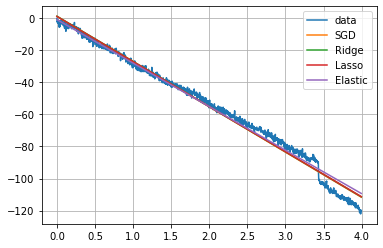

In [11]:
from sklearn.linear_model import SGDRegressor, ElasticNet, Lasso, Ridge
sgd_reg = SGDRegressor()
ridge_reg = Ridge(alpha=0.1)
lasso_reg = Lasso(alpha=0.1)
ela_reg = ElasticNet(alpha=0.1,l1_ratio=0.5)

# prep the data again
x = np.asarray(date_year[0:4*365]).reshape(-1,1)
y = np.asarray(ue[0:4*365]).reshape(-1,1)
x = x-np.min(x)
G = np.c_[np.ones((len(x),1)),x]
scale = (np.max(y)-np.min(y)) # minmax scaling

# Fit
sgd_reg.fit(x,y)
ridge_reg.fit(x,y)
lasso_reg.fit(x,y)
ela_reg.fit(x,y)

# make prediction
y_sgd=sgd_reg.predict(x)
y_sridge=ridge_reg.predict(x)
y_lasso=lasso_reg.predict(x)
y_ela=ela_reg.predict(x)

w_sgd=[sgd_reg.intercept_[0],sgd_reg.coef_[0]]
w_ridge=[ridge_reg.intercept_[0],ridge_reg.coef_[0]]
w_lasso=[lasso_reg.intercept_[0],lasso_reg.coef_[0]]
w_ela=[ela_reg.intercept_[0],ela_reg.coef_[0]]
print(w_sgd,w_ridge,w_lasso,w_ela)

fig,ax=plt.subplots(1,1)    
ax.plot(x,y);ax.grid(True)
ax.plot(x,G.dot(w_sgd))
ax.plot(x,G.dot(w_ridge))
ax.plot(x,G.dot(w_lasso))
ax.plot(x,G.dot(w_ela))
ax.legend(['data','SGD','Ridge','Lasso','Elastic'])

/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python

(0.0, 30.0)

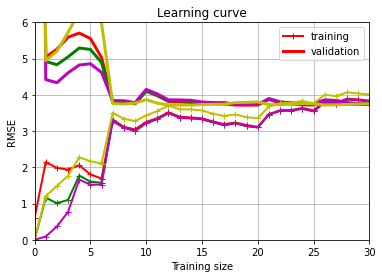

In [12]:
# perform the regressions
plot_learning_curves(sgd_reg, x.ravel(), y.ravel(),"r-+","r")
plot_learning_curves(ridge_reg, x.ravel(), y.ravel(),"g-+","g")
plot_learning_curves(lasso_reg, x.ravel(), y.ravel(),"m-+","m")
plot_learning_curves(ela_reg, x.ravel(), y.ravel(),"y-+","y")
plt.ylim([0,6])
plt.xlim([0,30])

We see that there needs to be at least 10 samples in the training set for the models to generalize reasonably well. We also  see that all of the regularization mechanisms yield seemingly similar behavior at the training. After a sufficient number of samples, validation loss goes below training loss.

**model complexity**

Now we will try and fit the step in the data.



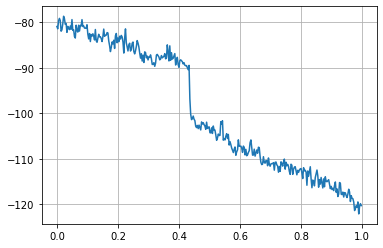

In [13]:
x = np.asarray(date_year[3*365:4*365]).reshape(-1,1)
y = np.asarray(ue[3*365:4*365]).reshape(-1,1)
x = x-np.min(x)
# G = np.c_[np.ones((len(x),1)),x]
scale = (np.max(y)-np.min(y)) # minmax scaling
newy = y / scale
plt.plot(x,newy*scale);plt.grid(True)


The data looks complex, with the superposition of a linear trend and oscillatory signals. Let's fit a general polynomial form. We will start with a simple model.

(365, 3)


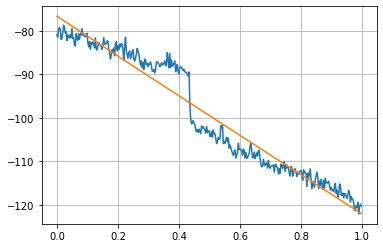

In [14]:
from sklearn.preprocessing import PolynomialFeatures


#Let's start with a simple
poly_features = PolynomialFeatures(degree=2)
G = poly_features.fit_transform(x) # G now contains the original feature of X plus the power of the features.


ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(G,y)
y_ridge=ridge_reg.predict(G)
print(G.shape)

plt.plot(x,y);plt.grid(True)
plt.plot(x,y_ridge)

(0.0, 100.0)

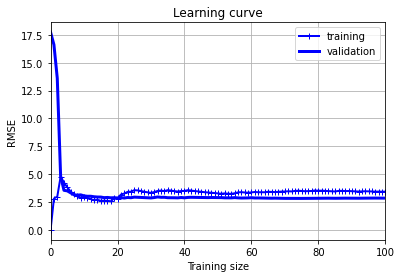

In [15]:
plot_learning_curves(ridge_reg, G.ravel(), y.ravel(),"b-+","b");plt.xlim([0,100])

(2.0, 4.0)

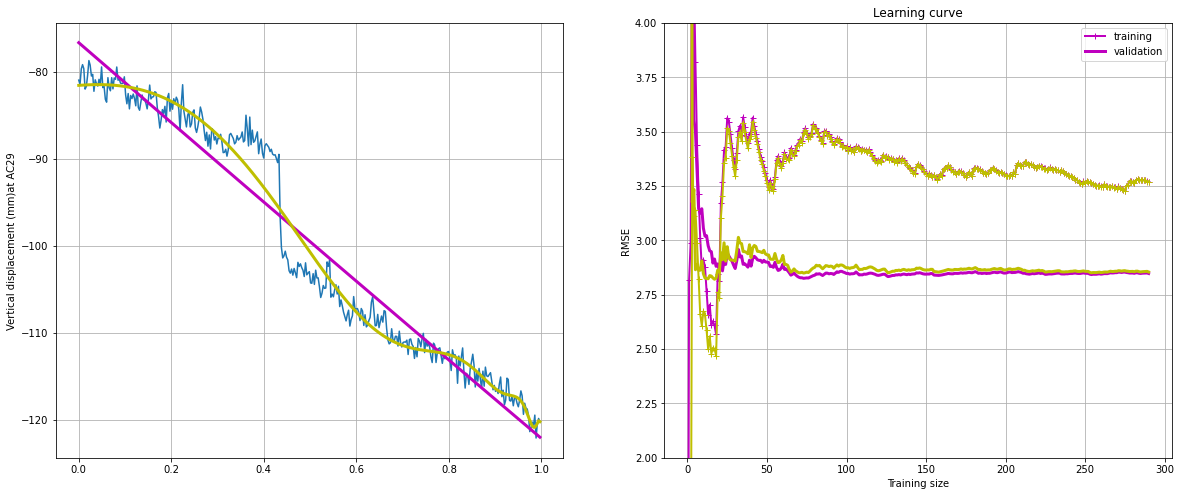

In [16]:
# Let's make it complex
poly_features = PolynomialFeatures(degree=400)
G2 = poly_features.fit_transform(x) # G now contains the original feature of X plus the power of the features.


ridge_reg2 = Ridge(alpha=0.001)
ridge_reg2.fit(G2,y)
y_ridge2=ridge_reg2.predict(G2)

fix,ax=plt.subplots(1,2,figsize=(20,8))
ax[0].plot(x,y);ax[0].grid(True)
ax[0].plot(x,y_ridge,"m",linewidth=3)
ax[0].plot(x,y_ridge2,"y",linewidth=3)
# ax[0].set_ylim([-10,20])
ax[0].set_ylabel('Vertical displacement (mm)at AC29')
plot_learning_curves(ridge_reg, G.ravel(), y.ravel(),"m-+","m");#plt.xlim([0,200])
plot_learning_curves(ridge_reg2, G2.ravel(), y.ravel(),"y-+","y");#plt.xlim([0,200])
plt.ylim([2,4])

# 4) Early stopping


In gradient descent, learning of the algorithm means that we are "training" the algorithm iteratively. As we keep training the model.

Another strategy to regularize the learning is to stop training as soon as the validation error reaches a minimum. Now instead of looking at the errors as a function of training size, we look at them as a function of epoch.

(0.0, 30.0)

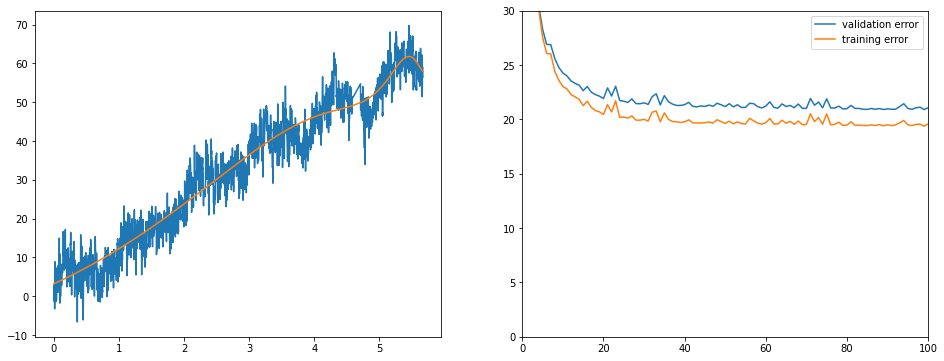

In [58]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

x = np.asarray(date_year[:]).reshape(-1,1)
x=x-np.min(x)
y = np.asarray(uv[:]).reshape(-1,1)



X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3,random_state=42)

# use the Pipeline function from sklearn to get prepare your data.
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=50)),
        ("std_scaler", StandardScaler()) ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_poly = poly_scaler.fit_transform(x)
X_val_poly_scaled = poly_scaler.transform(X_val)

# set the gradient with a single iteration since we will iterate over epochs.
# warm_start=True says that you should keep the previous state of the model to retrain.
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
val_error=np.zeros(1000)
train_error=np.zeros(1000)

for epoch in range(1000):
    
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    
    val_error[epoch] = mean_squared_error(y_val, y_val_predict)
    train_error[epoch] = mean_squared_error(y_train, y_train_predict)
    
    if val_error[epoch] < minimum_val_error: # you will stop and save the best model
        
        minimum_val_error = val_error[epoch]
        best_epoch = epoch
        best_model = clone(sgd_reg)
        best_y = sgd_reg.predict(X_poly)
        
        
        
fig,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].plot(x,y);
ax[0].plot(x,best_y)
ax[1].plot(np.arange(1000),val_error)
ax[1].plot(np.arange(1000),train_error)
plt.legend(["validation error","training error"])
plt.xlim([0,100]);plt.ylim([0,30])


You may also consider the parameter ``early_stopping=True`` in SGD to automatically implement early stopping and deal with overfitting.

# 5) Training Classification algorithms


Last week, we explored the ***logistic regression***, a classification method to estimate the probability that an instance belongs to a particular class. Here we take example of a binary classificaiton. The Logistic regression estimates the probability that an instance belongs to the positive class. If the probably is ablove a threshold, then the instance is classified in the positive class. The probability is estimted using a **logistic sigmoid function**:

$\sigma(x) = \frac{1}{1+ \exp(-x)}$

Training a logistic regression is to tune the model such that the output score is low for a negative instance and high for a positive instance. The loss function associated with logistic regression is the $\log$ function due to its property that it is really high at low values of $x$ and really low at high values of $x$. The cost function over a batch of $m$ instances it the sum of the individual instance cost functions, which is called the ***Log Loss**:


$ \mathcal{L}(\mathbf{w}) = - \frac{1}{m} \sum_{i=1}^m \left[ y_i \log(\hat{p}_i(\mathbf{w})) + (1 - y_i) \log(1-\hat{p}_i(\mathbf{w}))\right]  $, 

where $m$ is the number of instances, $\hat{p}_i = \sigma(\mathbf{w}(x)) $ is the probability output by the model of the instence $x$, and $y_i$ is the class of the instance. The log loss is differentiable with respect to the model parameters, and one can use Gradient Descent to optimize the model parameters.

In Scikit-learn, ``LogisticRegression`` is equivalent to training an logistic regression using a log loss ``SGDClassifier(loss='log')``.


The K-class version of logistical regression is the ***softmax or multinomial regression***. The softmax regression model first computes scores $s_k$ for each class, which are computing using a simple linear regression prediction. The probabilities are calculated using the softmax function:

$\hat{p}_k = \sigma(s_k) = \frac{\exp(s_k)}{ \sum_{i=1}^K \exp(s_i)}$

An appropriate loss function to use is called ***Cross Entropy*** cost function:


$ \mathcal{L}(\mathbf{w}) = - \frac{1}{m} \sum_{i=1}^m  \sum_{i=1}^K y_i \log(\hat{p}_i(\mathbf{w}))  $. 


The rest of the training requires similar tricks than the regression model training. The performance metrics are precision, recall, F1 scores etc etc as seen in previous notes.


# Checklist for training an ML model

1. Set the test set aside.
2. Initialize model parameters for optimizer (e.g. SGD)
3. Identify and define machine learning methods
4. Define the Loss Function

There are loss functions for classification (most of them use logs) and for regressions (they may use exponentials). Follow the documentation of your ML API: https://keras.io/api/losses/, https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics, https://pytorch.org/docs/stable/nn.html#loss-functions

5. Define the optimization algorithm 
The most popular optimizer algorithms compute the first derivative (gradient) of the loss functions. They include Gradient Descent, Momentum, Adagrad, RMSProp, Adam.
6. Model training

Prepare the folds for K-fold cross validation. Scale the data.
Define the model parameters in a dictionary. Define the number of epochs, learning rate, batch size.

For each fold:
Initialize the model parameters.
for each epoch (iteration), train the algorithm on a minibatch of training examples. Training consists in 1) passing the training data through our model to obtain a set of predictions, 2) calculating the loss, 3) computing the gradient (either known, or using backward passes in neural networks), and 4) updating the model parameters using an optimization algorithm (e.g. Stochastic Gradient Descent).


7. Fine tune the training

Compute learning rate as a function of training size to get a sense for the batch size desired to properly train.

Compute the validation and training error as a function of epochs. Find the minimum of the validation error and stop the training there.